In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


In [3]:
sns.set_style("darkgrid")
sns.set_palette("twilight")
sns.set_context("notebook")
pd.options.display.max_rows = 200

%config InlineBackend.figure_format='retina'
mpl.rcParams['figure.dpi'] = 90


Every year since 2011, Stack Overflow has conducted a survey to ask developers a variety of question about what it's like to work as a developer. The questions cover a lot of ground: demographic information, learning goals, values, and opinions. The main insights from the last published edition of the survey can be found here.

Since it's such a long survey, there are different types of information that can be extracted from it, and the link I provided doesn't cover all the possibilities. I was curious in particular about *job and career satisfaction* among developers, and the factors that influence it.

The survey includes two separate columns for Career Satisfaction  and Job Satisfaction. I've decided to focus on analyzing on **job satisfaction** out of the two, because I think that a lot of the interesting variables in the dataset, like the organization size and the opportunity for remote work, are related to a single job rather than a career.

This notebook will try to find the answer to different questions, like:

* Are developers happier at larger or smaller organizations?

* Are men (or women) developers more likely to be satisfied with their job?

* How does compensation correlate to job satisfaction?

### Importing data and preliminary analysis

The original dataset contains 85 columns, mostly categorical. Since my goal is to only investigate job satisfaction, I think that only some of the original 85 columns are actually relevant to our analysis.To avoid cluttering the notebook, I've already excluded the features that I don't find useful, such as the developer's learning goals for 2020 and their experience with StackOverflow.

In [4]:
survey_raw = pd.read_csv("data/survey_results_public_reduced.csv", header = 0, sep = ';', encoding = 'ISO 8859-1')

In [5]:
survey_raw.head()

,MainBranch,Hobbyist,OpenSourcer,Employment,Country,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,...,JobSat,MgrWant,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,ImpSyn,Age,Gender
0,I am a student who is learning to code,Yes,Never,"Not employed, and not looking for work",United Kingdom,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,Man
1,I am a student who is learning to code,No,Less than once per year,"Not employed, but looking for work",Bosnia and Herzegovina,"Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,Man
2,"I am not primarily a developer, but I write co...",Yes,Never,Employed full-time,Thailand,"Bachelors degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",...,Slightly satisfied,Not sure,8820.0,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / Never,Average,28.0,Man
3,I am a developer by profession,No,Never,Employed full-time,United States,"Bachelors degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,100 to 499 employees,"Developer, full-stack",...,Slightly satisfied,Not sure,61000.0,80.0,There's no schedule or spec; I work on what se...,NaN,Less than once per month / Never,A little below average,22.0,Man
4,I am a developer by profession,Yes,Once a month or more often,Employed full-time,Ukraine,"Bachelors degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,"10,000 or more employees","Academic researcher;Developer, desktop or ente...",...,Slightly dissatisfied,No,NaN,55.0,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Inadequ...,A few days each month,A little above average,30.0,Man


Let's take a look at the **23 columns** we have available.

In [6]:
print(survey_raw.columns)
print(survey_raw.info(verbose = False))

Index(['MainBranch', 'Hobbyist', 'OpenSourcer', 'Employment', 'Country',
       'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize', 'DevType',
       'YearsCode', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrWant',
       'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge',
       'WorkRemote', 'ImpSyn', 'Age', 'Gender'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88883 entries, 0 to 88882
Columns: 23 entries, MainBranch to Gender
dtypes: float64(3), object(20)
memory usage: 15.6+ MB
None


As we can see, the dataset contains almost 90000 answers to the survey. However, **not all survey takers were developers**: the dataset also includes student, ex-devs and other categories. To figure out how many of these answers are from working developers, we can look at the *MainBranch* column.

#### Selecting data of interest

I will remove from the dataset:

* People who are not currently developers (e.g. student, ex developers)

* Part-time developers

* Answers from developer with less than 1 year of coding experience 

In [7]:
# only prof. developers
survey_dev = survey_raw[(survey_raw['MainBranch'] == 'I am a developer by profession')]

# exclude part time
survey_dev = survey_dev[(survey_dev['Employment'] == 'Employed full-time')
| (survey_dev['Employment'] == 'Independent contractor, freelancer, or self-employed') ]

# exclude less than 1 year coding
survey_dev = survey_dev[(survey_dev['YearsCodePro'] != 'Less than 1 year') | (survey_dev['YearsCode'] != 'Less than 1 year') ]
print(len(survey_dev))

61373


We're down to about **60000 rows**. Also, since Job Satisfaction is out target variable, it's best to drop the rows for which it's null - they're just a few hundred.

### Utility functions

In [21]:
#utility plotting function 
def plotJobSatisfaction(column, target = "JobSat", width = 5, height = 5, bartype = 'bar', norm = True):
    props = survey_dev.groupby(column)[target].value_counts(normalize=norm).unstack()
    props.plot(kind= bartype, stacked='True', figsize = (width,height),edgecolor = "none")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
    
def grouped_bars_fraction( x, y,hue,df = survey_dev):
    data = 100*(df[x].groupby(df[hue]).value_counts(normalize=True))
    data.rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue)
    
def lollipop(x,y,xshift=-0.2,yshift=7):
    plt.stem(y,use_line_collection = True)
    plt.xticks(range(0,len(x)), x);
    for index, value in enumerate(y):
        plt.text(index + xshift,value + yshift ,str(value)+'%')
        
def percentageSatisfied(column, dataset = survey_dev, rounding = 1):
    data = dataset.dropna(subset = [column])
    grouped_data_sat = survey_dev.loc[survey_dev.Satisfaction=='Satisfied'].groupby([column])[column].count()
    grouped_data_tot = survey_dev.groupby([column])[column].count()
    return np.round(grouped_data_sat/grouped_data_tot*100,rounding)

### Exploratory data analysis

First of all, I'd like to know the distribution of our target variable - **Job Satisfaction**. Even though I've decided not to further investigate **Career Satisfaction** , I'm still curious to see how it's distributed as well and how it compares to job satisfaction.

In [9]:
# Creating a long-format dataframe with pandas.melt
# to plot Job Satisfaction along Career Satisfaction in a bar plot
survey_melt = survey_dev.rename(columns={'JobSat':'Job Satisfaction', 'CareerSat':'Career Satisfaction'})
survey_melt = pd.melt(survey_melt, value_vars = ['Job Satisfaction', 'Career Satisfaction'],
                      var_name='Type', value_name='Satisfaction level')


In [10]:
survey_melt.sample(3)

,Type,Satisfaction level
51997,Job Satisfaction,Slightly satisfied
56563,Job Satisfaction,Slightly satisfied
52579,Job Satisfaction,Very satisfied


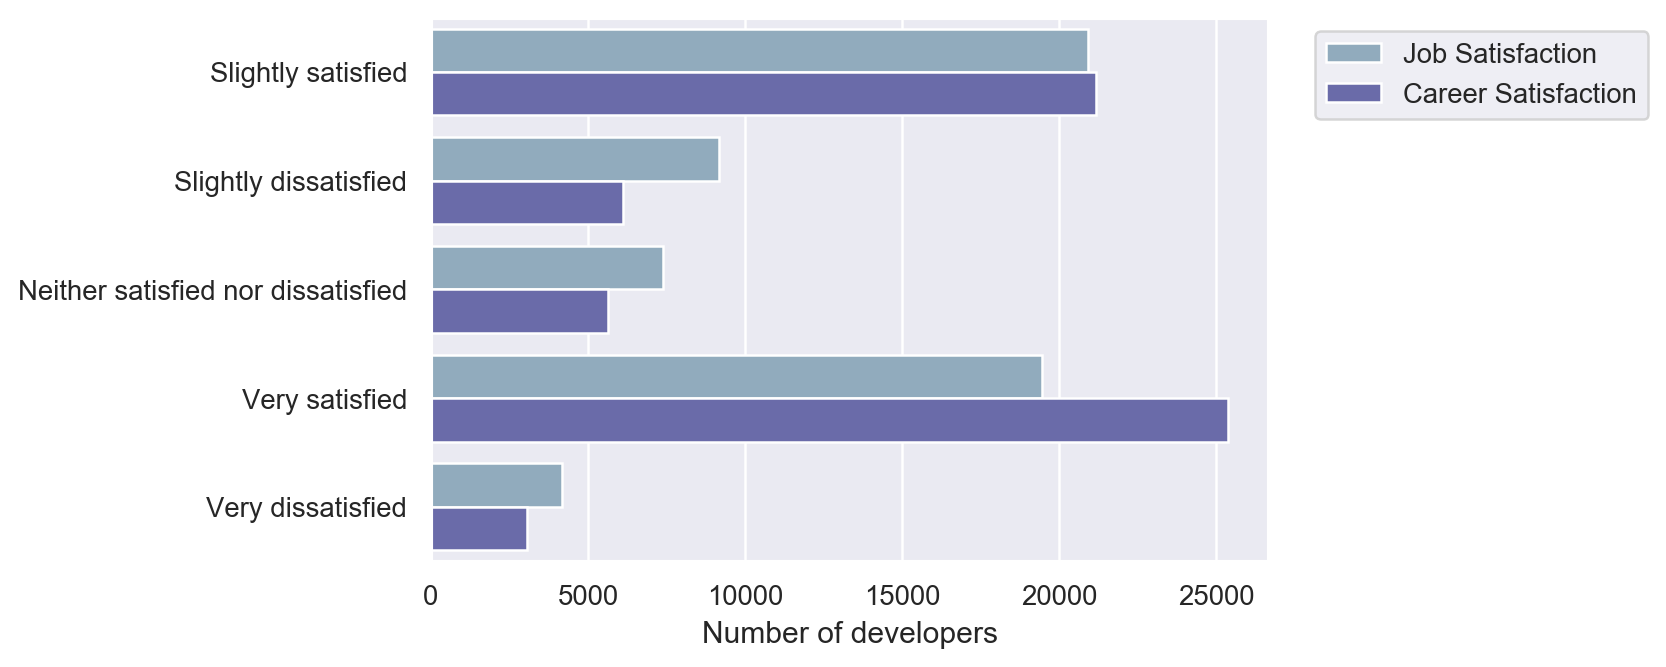

In [11]:
sns.countplot(y="Satisfaction level", hue="Type",data = survey_melt, orient = "h");
plt.xlabel("Number of developers");
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
plt.ylabel("");

Our data shows that about 66% of the respondents are satisfied with their job, and about 22% report being slightly or very dissatisfied. The rest are in the middle of the scale. That's a pretty encouraging result! It seems like, at least in this sample, developers are mostly content in their jobs. These values are even higher when you look at **career** satisfaction, which tells us that some developers are still evaluating their career positively even if they don't have the perfect job at the moment.

It's a bit messy to work with these many satisfaction levels, so I want to encode a new feature that simplifies this, with the pandas *.map()* method. The new column will have three possible values: *Satisfied*, *Unsatisfied* or *Neutral.*

In [12]:
survey_dev['Satisfaction'] = survey_dev['JobSat'].map({'Very satisfied':'Satisfied', 'Slightly satisfied':'Satisfied',
                                                'Neither satisfied nor dissatisfied': 'Neutral',
                                               'Slightly dissatisfied': 'Unsatisfied', 'Very dissatisfied':'Unsatisfied' })
print("Percentages:")
sat_percentages = np.round(100*survey_dev['Satisfaction'].value_counts()/len(survey_dev),1)
print(sat_percentages)

p_sat = 100*(survey_dev['Satisfaction']=='Satisfied').sum()/len(survey_dev)

Percentages:
Satisfied      65.8
Unsatisfied    21.7
Neutral        12.0
Name: Satisfaction, dtype: float64


#### Demographics

##### Age

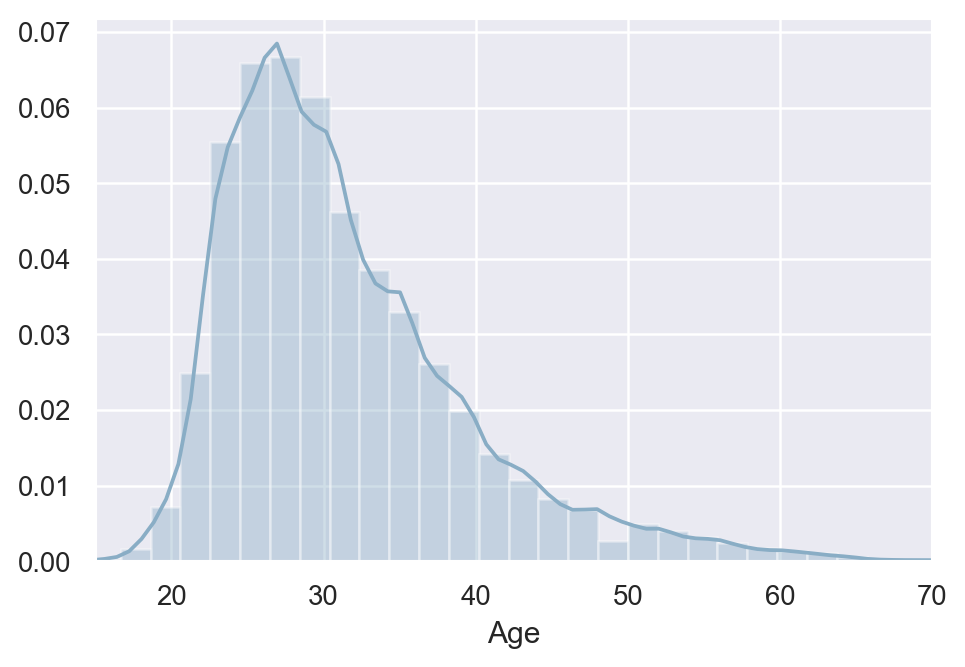

In [13]:
# Overall age distribution
sns.distplot(survey_dev['Age'])
plt.xlim(15, 70);

With an average age of 31 years, this distribution is skewed towards younger people. This is what I would expect, since IT professions have seen a dramatic increase in popularity in recent times. I wish we had more data for experienced developers.

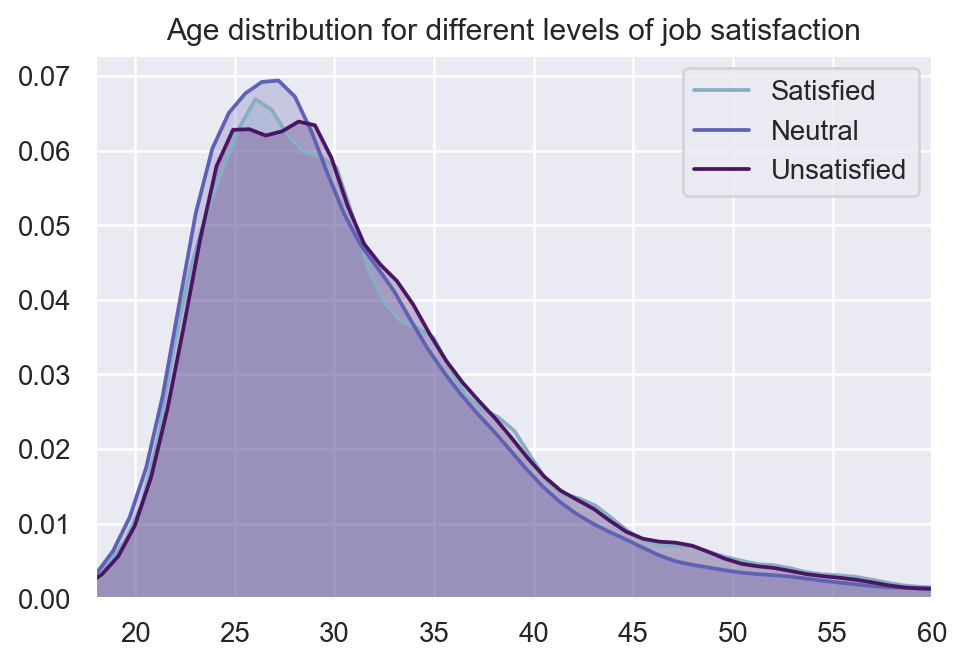

In [14]:
# Age distribution for the different job satisfaction categories
sat_values = ['Satisfied', 'Neutral', 'Unsatisfied']
for value in sat_values:
    data_p = survey_dev.loc[survey_dev['Satisfaction'] == value]['Age']
    sns.kdeplot(data = data_p, shade = True)
    
plt.xlim((18,60));
plt.title('Age distribution for different levels of job satisfaction')
plt.legend(sat_values);

As you can see, this plot doesn't really give me meaningful information. Each of the three groups still follows the overall age distribution, and it's difficult to make observations from just this plot.

I think that, to really find out if age is a factor, I need to somehow compare numerically the satisfaction rate for a certain age group against the **mean** satisfaction for all ages. 

So, let's first divide all the age values in bins of 10 years each, and then we can plot this percentage difference for each bin.

In [15]:
survey_dev['AgeGroup'] = pd.cut(x=survey_dev['Age'], bins=[20, 29, 39, 49, 59, 69])
age_groups = np.delete(np.array(survey_dev['AgeGroup'].unique()),3)
age_groups.sort()

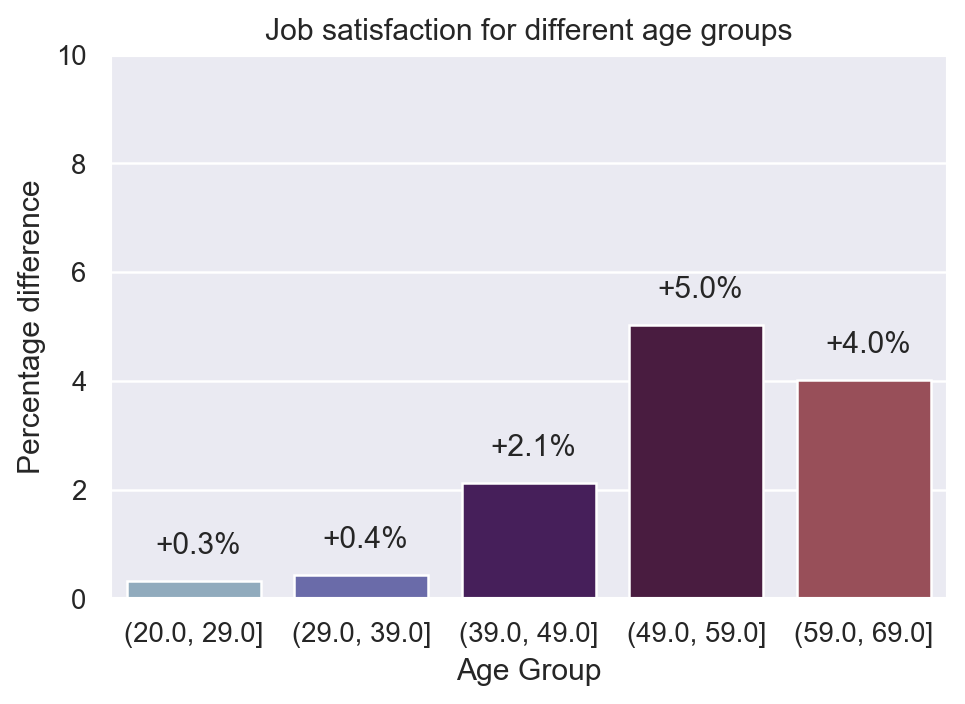

In [16]:
age_percentage_data = percentageSatisfied(column = 'AgeGroup')
sns.barplot(y=age_percentage_data- p_sat, x = age_groups)
for index, value in enumerate(age_percentage_data):
        plt.text(index -0.23,value-p_sat + 0.5,str('+'+ str(np.round(value-p_sat,1)))+'%')
# Line that shows the average percentage across all ages
plt.axhline(y=p_sat) 
plt.ylim(0,10)
plt.ylabel('Percentage difference')
plt.xlabel('Age Group')
plt.title('Job satisfaction for different age groups');

By looking at it this way, some pattern emerges. Let's remember that the average satisfaction rate was 65.8%, so a 5% increase on top of that that is pretty meaningful. People under 40 make up the majority of our data pool, so it makes sense that their satisfaction levels are basically equal to the average.

It's interesting to see how the rate increases with age (except from the last bin, which is made up of a very very small amount of data points). This information will tie in nicely with some observations on competence that are made in the next sections of the article.

##### Gender

To simplify the analysis I'm going to group all the responses other than "Man" and "Woman" in a 'Non-binary' column, and I'm also going to drop the null values. I'm aware that *non-binary* doesn't cover the entire spectrum of gender possibilities other than man and woman, but please consider it a shorthand for non-binary, genderqueer, or gender non-conforming.

In [17]:
#Gender
print(survey_dev['Gender'].value_counts() )

print('\nNumber of NULL gender values: ' + str(survey_dev['Gender'].isnull().sum()))

man_p = 100*(len(survey_dev[survey_dev['Gender'] == 'Man']) / len(survey_dev))
print('Percentage of developers who identify as men: ' + str(np.round(man_p,2)) + '%')
# Creating a new category
survey_dev['Gender'] = np.where(((survey_dev['Gender'] != 'Man') & (survey_dev['Gender'] != 'Woman')), 'Non-binary', survey_dev['Gender'])

Man                                                            54731
Woman                                                           4000
Non-binary, genderqueer, or gender non-conforming                359
Man;Non-binary, genderqueer, or gender non-conforming            109
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         56
Woman;Man;Non-binary, genderqueer, or gender non-conforming       34
Name: Gender, dtype: int64

Number of NULL gender values: 1992
Percentage of developers who identify as men: 89.18%


It's probably not a surprise that the overwhelming majority of people who answered the survey are male. Since they make up most of the data, they set the average with regards to job satisfaction, so it will only be meaningful to look at how women and non-binary people evaluate their job, to see if it's different from the mean. Let's do that now.

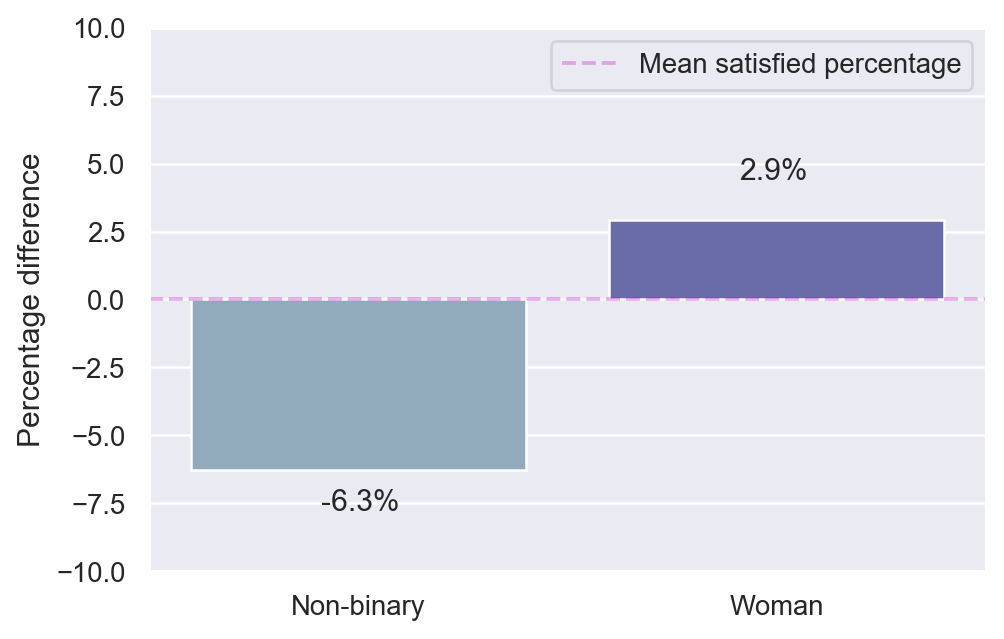

In [18]:
gender_percentage_data = percentageSatisfied(column = 'Gender').drop(['Man'])

sns.barplot(y=gender_percentage_data- p_sat, x = ['Non-binary', 'Woman'])
for index, value in enumerate(gender_percentage_data):
        plt.text(index -0.09,value-p_sat + 1.5*np.sign(value-p_sat),str(np.round(value-p_sat,1))+'%')
plt.axhline(0, label = 'Mean satisfied percentage', c = 'm', ls = '--', alpha = 0.3)
plt.legend()

# Line that shows the average percentage across all ages
plt.ylim(-10,10)
plt.ylabel('Percentage difference');

I don't feel comfortable making comments on any patterns that emerge from this plot, because I have such a small sample of women and non-binary people. There's no guarantee that any observations would generalize well.

Still, if I had to comment on the data, I would say that non-binary people are less satisfied than average, and women slightly more. Of course, you could argue that women might have lower expectations since this field has historically been hostile to them, so it might take less to make them say they're content with what they have. Food for thought.

In their own analysis, Stack Overflow observed that non-binary people value **Diversity** in the organization more highly than other demographics. The discontent we see in this data could stem from their dissatisfaction about the current state of diversity in tech.

#### Education

One thing I wondered is whether people who work in the field that they studied for are more satisfied than others. For developers, the "relevant" majors to consider would be (as they appear in the *UndergradMajor* column):

* Web development or web design (front-end and full-stack developers)

* Computer science, computer engineering, or software engineering

* Information systems, information technology, or system administration

I will also consider the subcategory of people who work in data science and studied Mathematics/Statistics, since they are technically working in their study fields.

In [19]:
survey_dev = survey_dev.assign(SameField='No')
# Developers who have relevant majors
majors = ((survey_dev['UndergradMajor'].str.contains('web')) 
        |(survey_dev['UndergradMajor'].str.contains('computer'))
        | (survey_dev['UndergradMajor'].str.contains('information')) )
# Developers working in data 
data_scientist = ((survey_dev['DevType'].str.contains('Data scientist'))
                  & (survey_dev['UndergradMajor'].str.contains('statistics')))

survey_dev['SameField'] = np.where(majors, 'Yes', survey_dev['SameField'])
survey_dev['SameField'] = np.where(data_scientist, 'Yes', survey_dev['SameField'])


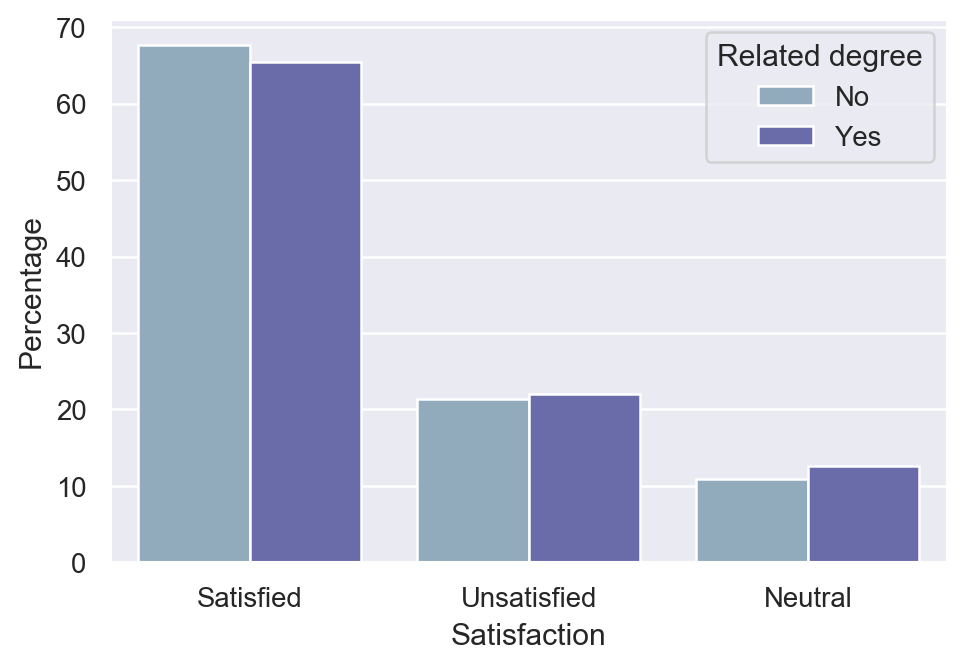

In [22]:
grouped_bars_fraction(x= "Satisfaction",y = "Percentage", hue = "SameField")
plt.legend(title = "Related degree");

There's not much in the plot that catches my eye, I think that the differences are very small here.

#### Work-related

##### Compensation

In [23]:
country_count = survey_dev['Country'].unique().size
print(f"There are {country_count} different countries in the survey.")
top_countries =  survey_dev['Country'].value_counts()[:10]
print('The ten countries with the highest number of respondents are:')
print(top_countries)

There are 167 different countries in the survey.
The ten countries with the highest number of respondents are:
United States         15356
India                  6327
United Kingdom         4322
Germany                3817
Canada                 2373
France                 1663
Brazil                 1368
Poland                 1361
Australia              1343
Russian Federation     1213
Name: Country, dtype: int64


In [24]:
# Country 
survey_dev['CountryCat'] = survey_dev['Country']
survey_dev['CountryCat'] = np.where(((survey_dev['Country'] != 'United States') 
                                     & (survey_dev['Country'] != 'United Kingdom')
                                     & (survey_dev['Country'] != 'India'))
                                    , 'Other', survey_dev['Country'])
not_us_uk = (survey_dev['CountryCat']=='Other').sum() + (survey_dev['Country']=='India').sum()
print(f"There are {not_us_uk} developers who work outside of the US and the UK.")

There are 41695 developers who work outside of the US and the UK.


As you see, a good chunk of the respondents aren't from the United States or UK. India is very well represented, along with other countries all over the world.

This makes my job trickier since we cannot just analyze the *Compensation* column as it is. Since compensation has been converted to US dollars for all survey respondents, it cannot give us any reliable information since the same amount of money will lead to wildly different purchasing powers in different countries.

It will only be an useful metric when looking at **developers working in the US**, and that's what I'm going to do since we still have a decently sized sample.

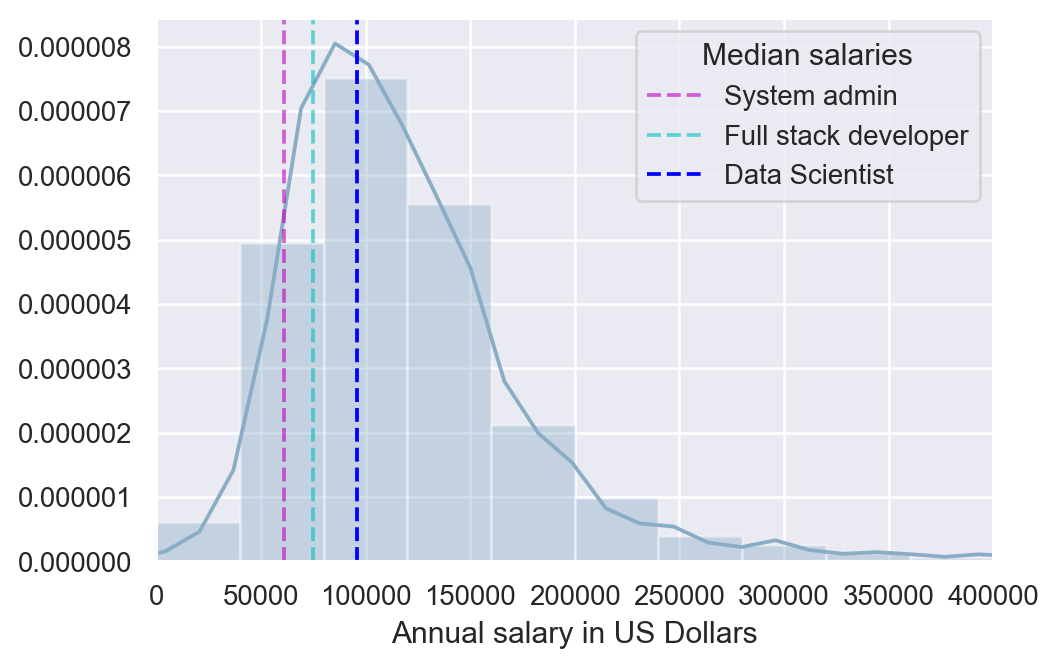

In [25]:
# select only people from the US
survey_usa = survey_dev.loc[survey_dev['Country']=='United States']
# Plot with vertical lines indicating
# avg salaries for different positions
sns.distplot(survey_usa['ConvertedComp']);
plt.xlim(0,400000)
plt.axvline(61000, label = 'System admin', ls = '--', c = 'm', alpha = 0.6)
plt.axvline(75000, label = 'Full stack developer', ls = '--', c = 'c', alpha = 0.6)
plt.axvline(96000, label = 'Data Scientist',ls = '--', c = 'b')
plt.legend(title = "Median salaries")
plt.xlabel("Annual salary in US Dollars");

> I had to cut the plot because of some outliers on the far right, at around 2 million dollars. I'm inclined to believe that they were fake data points, so I won't analyze them further.

In [29]:
# Creating different compensation brackets
survey_dev['Compensation'] = pd.cut(x=survey_dev['ConvertedComp'], bins=[0,25000,50000,75000,125000,175000,250000,600000])
comp_groups = np.delete(survey_dev['Compensation'].unique(),1)
# Replacing interval names
comp_groups_short = ['<25K', '25K-50K','50K-75K' ,'75K-125K', '125K-175K', '175K-250K', '>250K']
for i in range(len(comp_groups)):
    comp_groups[i] = comp_groups_short[i]

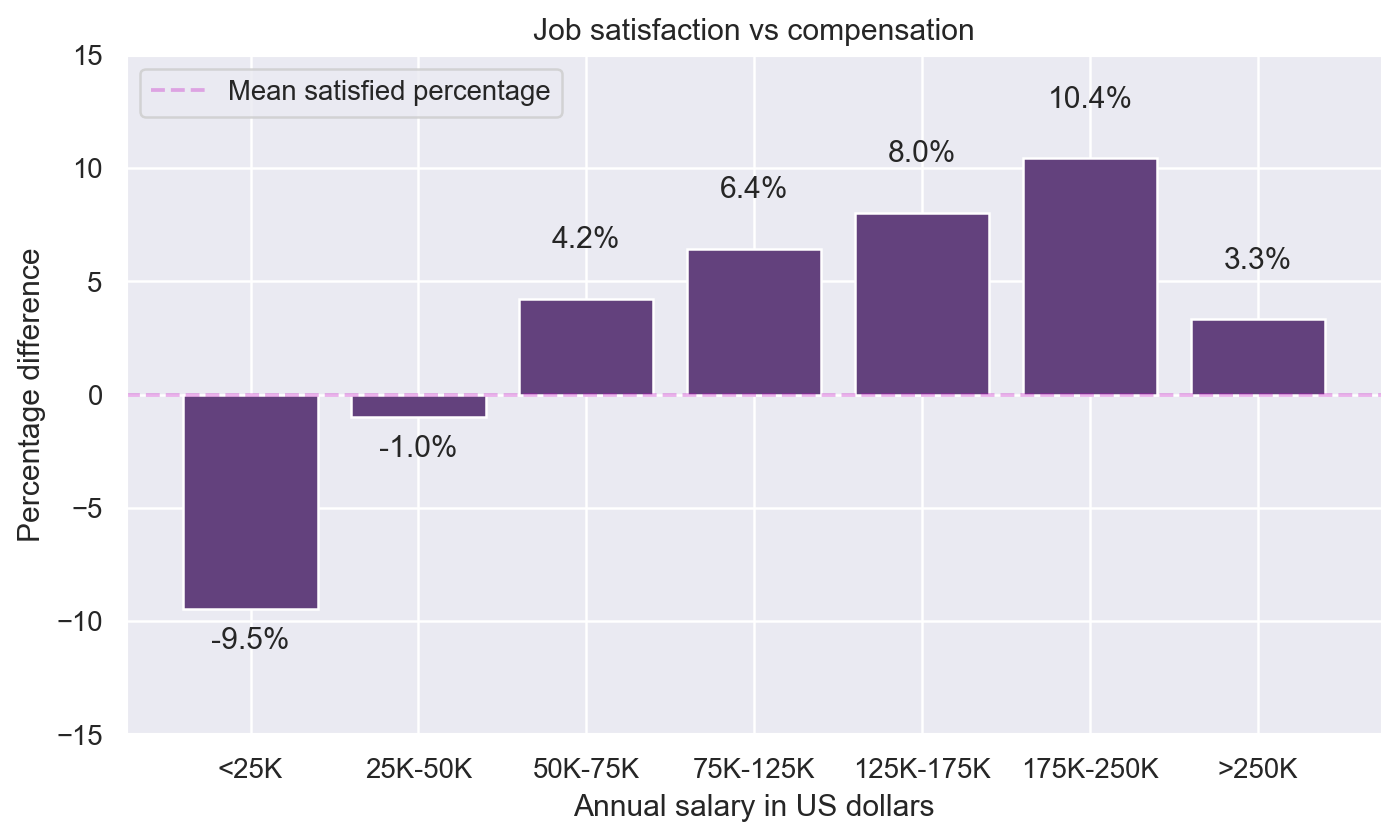

In [30]:
# Plotting staisfaction for each bracket
survey_comp = survey_dev.dropna(subset = ['Compensation'])
comp_percentage_data = percentageSatisfied(column = 'Compensation')
plt.figure(figsize = (9,5))

bar1 = plt.bar(comp_groups,comp_percentage_data- p_sat, color = '#63417d')

# adding text labels to each bar
for rect in bar1:
    height = np.round(rect.get_height(),1)
    plt.text(rect.get_x() + rect.get_width()/2.0, height+np.sign(height)*2, str(height)+'%', ha='center', va='bottom')
# Line that shows the average percentage across all ages
plt.axhline(0, label = 'Mean satisfied percentage', c = 'm', ls = '--', alpha = 0.3)

# Legend and labels
plt.legend(loc="upper left")
plt.ylim(-15,15)
plt.ylabel('Percentage difference')
plt.xlabel('Annual salary in US dollars')
plt.title('Job satisfaction vs compensation');

As you can see the brackets aren't all the same size, because I wanted to look more closely at some areas.

I can't say these result surprise me: the worst decrease in satisfaction occurs among people who are paid well below the average. Among people that make more than 50K dollars a year, satisfaction keeps increasing for each bracket. The only exception is the highest bracket, but if we look at the distribution of the survey data, there are very few people with a salary in this range.

##### Organization size

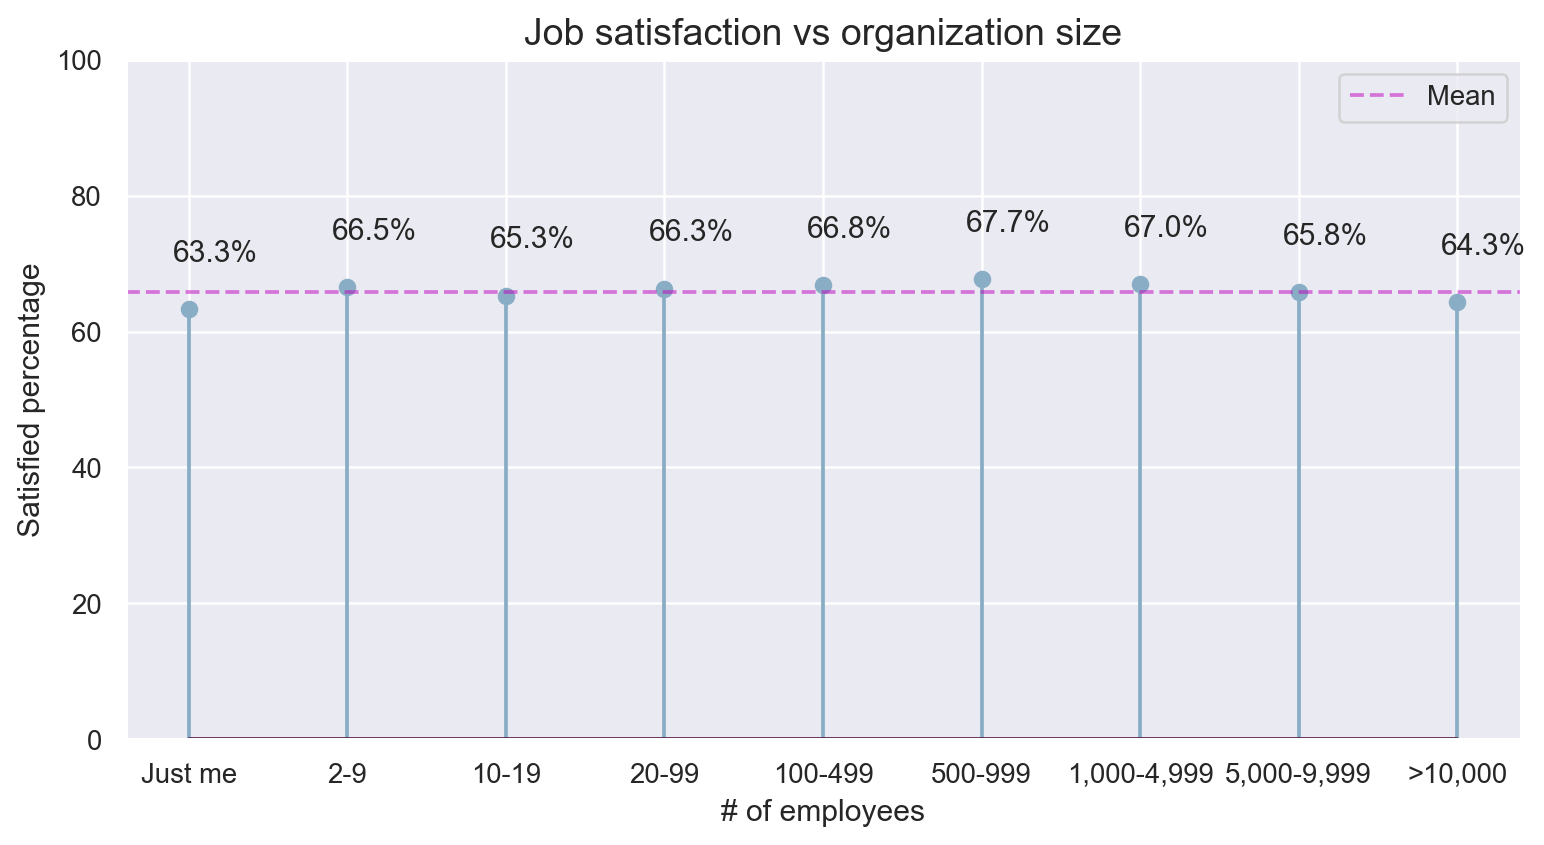

In [31]:
size_categories = ['Just me - I am a freelancer, sole proprietor, etc.','2-9 employees',
          '10 to 19 employees','20 to 99 employees','100 to 499 employees',
          '500 to 999 employees','1,000 to 4,999 employees', '5,000 to 9,999 employees',  '10,000 or more employees']
# The plots will look better with shorter category names
size_categories_short = ['Just me','2-9',
          '10-19','20-99','100-499',
          '500-999','1,000-4,999', '5,000-9,999',  '>10,000']


orgsize_satisfied = percentageSatisfied(column = 'OrgSize', dataset = survey_dev).reindex(size_categories)
plt.figure(figsize=(10,5))
lollipop(size_categories_short, orgsize_satisfied, xshift= -0.1)
plt.ylim(0,100);
plt.axhline(p_sat, color = 'm', ls = '--', alpha = 0.5, label = 'Mean')
plt.legend()
plt.ylabel('Satisfied percentage')
plt.title('Job satisfaction vs organization size', fontsize = 15);
plt.xlabel('# of employees');

There doesn't seem to be any strong correlation between the number of employees in a company and job satisfaction.

##### Working remotely

Text(0.5, 1.0, 'How often do you work remotely?')

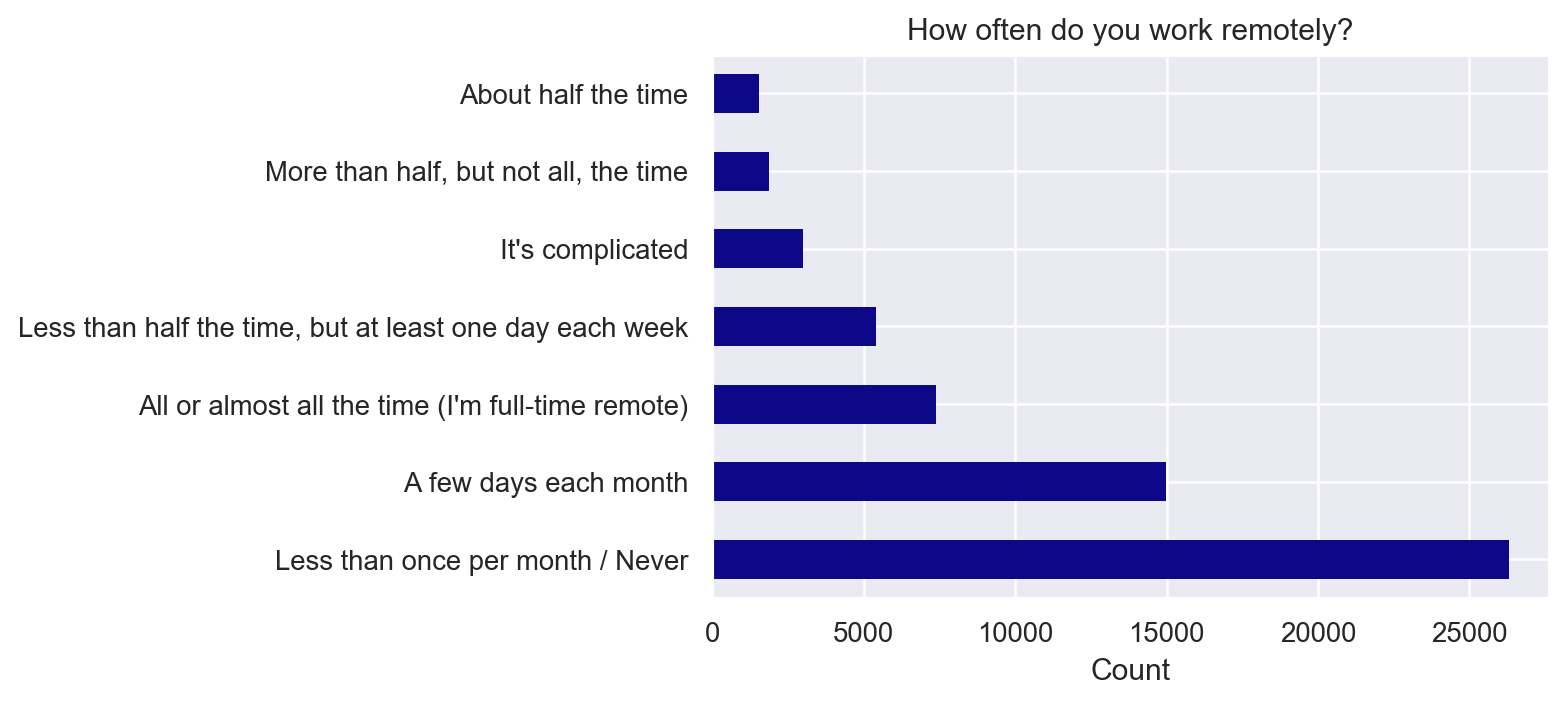

In [32]:
survey_dev['WorkRemote'].value_counts().plot(kind='barh',edgecolor = "none", cmap = 'plasma');
plt.xlabel('Count');
plt.title("How often do you work remotely?")

The WorkRemote field has way too many values for my taste, so I'm going to refactor this column, since I still think it will be interesting to study it. I want to end up with three categories: *full-time remote, sometimes remote, not remote*.

In [33]:
# new Remote column 
remote_cat = ['Never', 'Part-time remote', 'Full-time remote']
survey_dev = survey_dev.assign(Remote='Never')

full_time = (survey_dev['WorkRemote'].str.contains('all or almost'))
part_time = ( (survey_dev['WorkRemote'].str.contains('week'))
          | (survey_dev['WorkRemote'].str.contains('half'))
             | (survey_dev['WorkRemote'].str.contains('few')) )

survey_dev['Remote'] = np.where(full_time, 'Full-time remote', survey_dev['Remote'])
survey_dev['Remote'] = np.where(part_time, 'Part-time remote', survey_dev['Remote'])

survey_dev['Remote'].value_counts()

Never               36682
Part-time remote    23823
Full-time remote      868
Name: Remote, dtype: int64

Full-time remote developers are really rare, as I expected. Let's see if we can detect some satisfaction pattern.

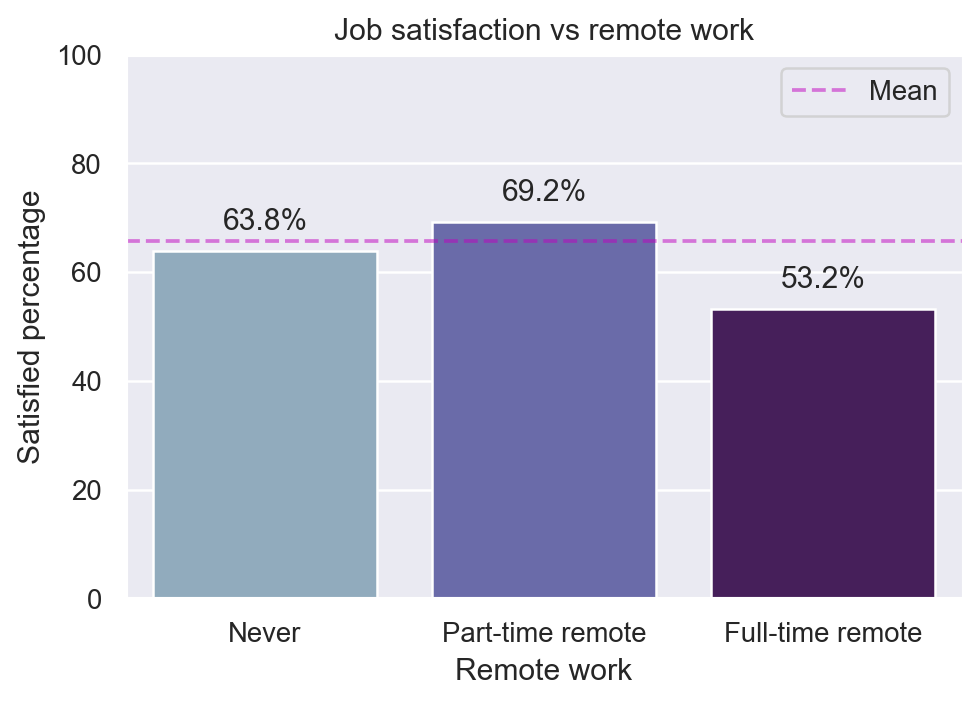

In [34]:
remote_satisfied = percentageSatisfied(column = 'Remote', dataset = survey_dev).reindex(remote_cat)
sns.barplot(y=remote_satisfied, x = remote_cat)
plt.xlabel('Remote work');
for index, value in enumerate(remote_satisfied):
        plt.text(index -0.15,value + 4,str(value)+'%')
plt.ylim(0,100);
plt.axhline(p_sat, color = 'm', ls = '--', alpha = 0.5, label = 'Mean')
plt.legend()
plt.ylabel('Satisfied percentage');
plt.title('Job satisfaction vs remote work');


Now, as I mentioned before, **full-time remote developers** make up a tiny part of our dataset, so we don't know if it's a representative sample. However, the data we do have tells that these workers are **much less satisfied** than average, while developers who *sometimes* work remotely are about 5% more satisfied.

It might be interesting to compare these findings to those reported in Buffer's latest[ State of Remote Work](https://lp.buffer.com/state-of-remote-work-2020 "https://lp.buffer.com/state-of-remote-work-2020") survey. Their survey was mostly focused on remote workers, so their insights are probably more reliable.

##### Competence at work

We still haven't talked about the *ImpSyn* column, which contains the answer to the question:

> For the specific work you do, and the years of experience you have, how do you rate your own level of competence?

I think competence is an interesting thing to look at in this context. Various influential thinkers (such as [Cal Newport](https://www.calnewport.com/books/so-good/ "https://www.calnewport.com/books/so-good/") in his book *Be so good they can't ignore you*, which I recommend) believe that job satisfaction doesn't come from innate passion, but rather from *becoming very good at what you do*. If they are right we might see some correlation between these two variables.

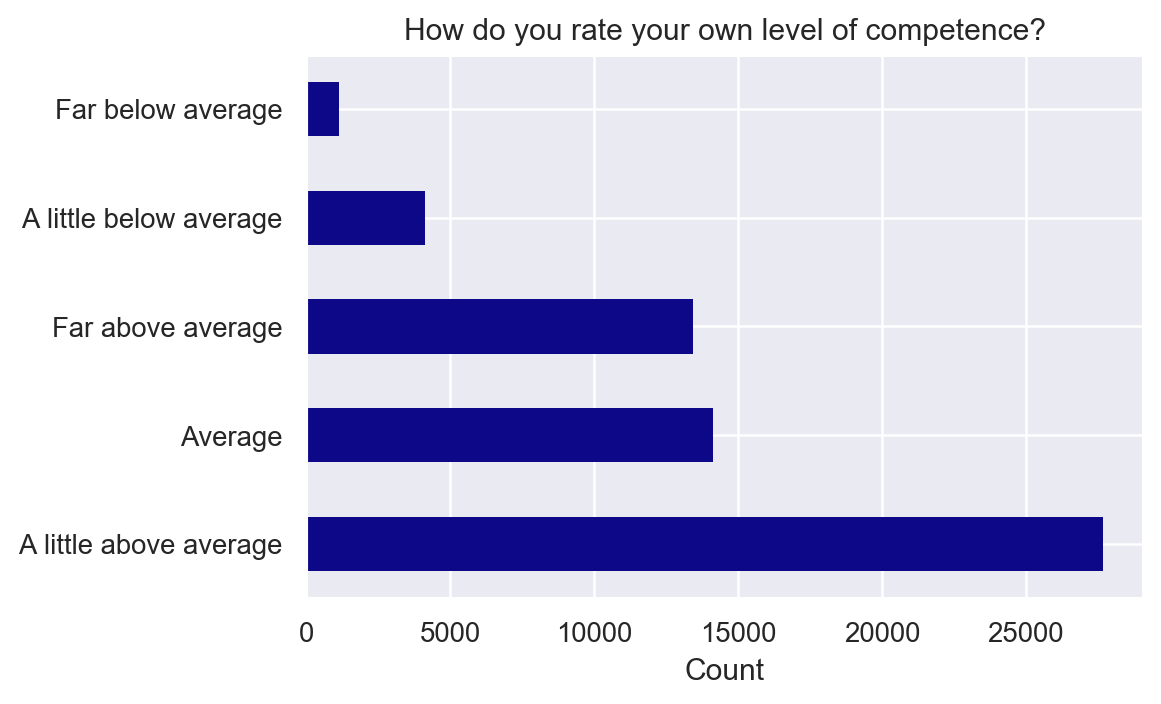

In [35]:
survey_dev['ImpSyn'].value_counts().plot(kind='barh',edgecolor = "none", cmap = "plasma");
plt.xlabel("Count");
plt.title('How do you rate your own level of competence?');

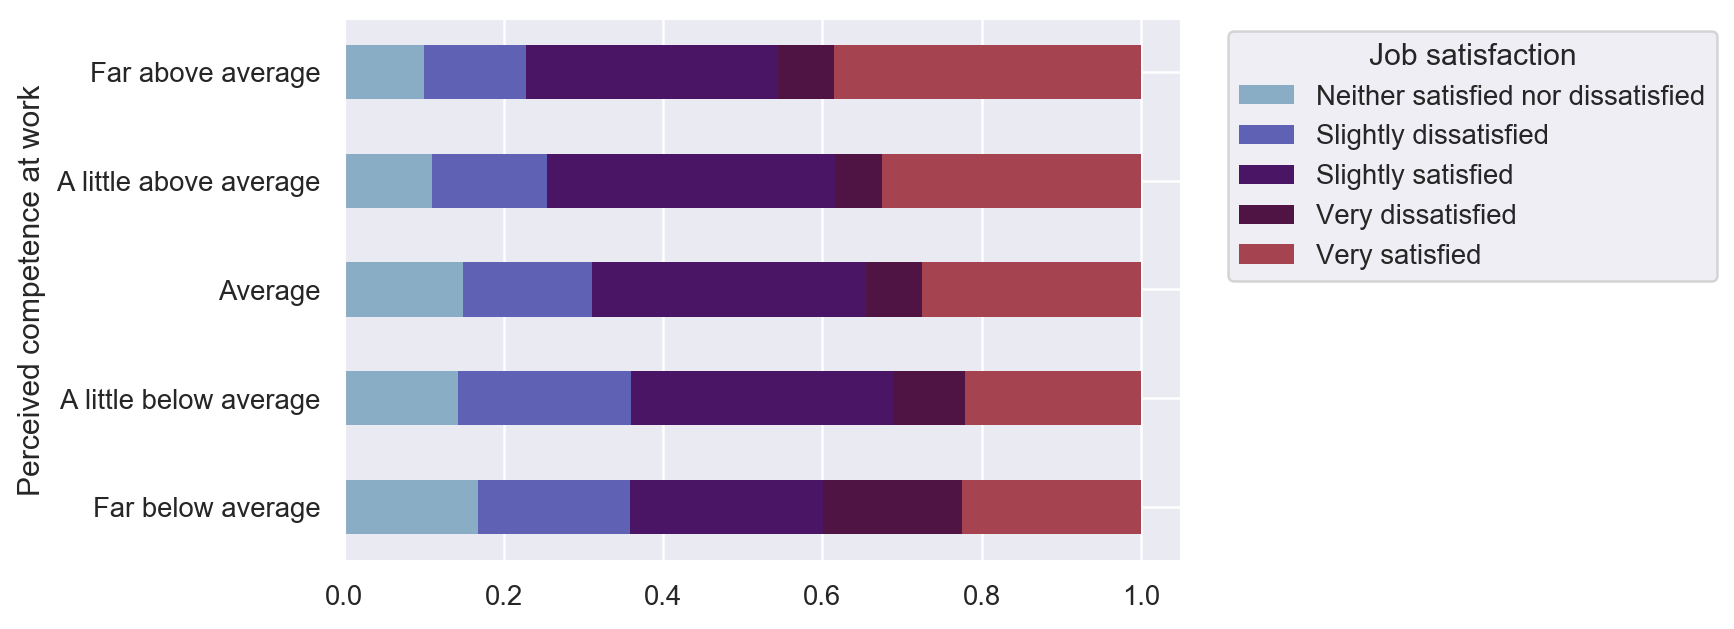

In [36]:
props = survey_dev.groupby('ImpSyn')['JobSat'].value_counts(normalize=True).unstack()
categories =  ["Far below average", "A little below average", "Average", "A little above average", "Far above average"]
props = props.reindex(categories)
props.plot(kind= 'barh', stacked='True',sort_columns = False,edgecolor= "none" )
plt.ylabel("Perceived competence at work")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title = "Job satisfaction");

There's definitely **something there**. Developers who perceive themselves as having below average abilities are clearly less satisfied at work compared to their more competent (or at least more confident) colleagues.

The difference is even more striking if we plot these competence categories against the percentage of developers who are in the *Satisfied* category.

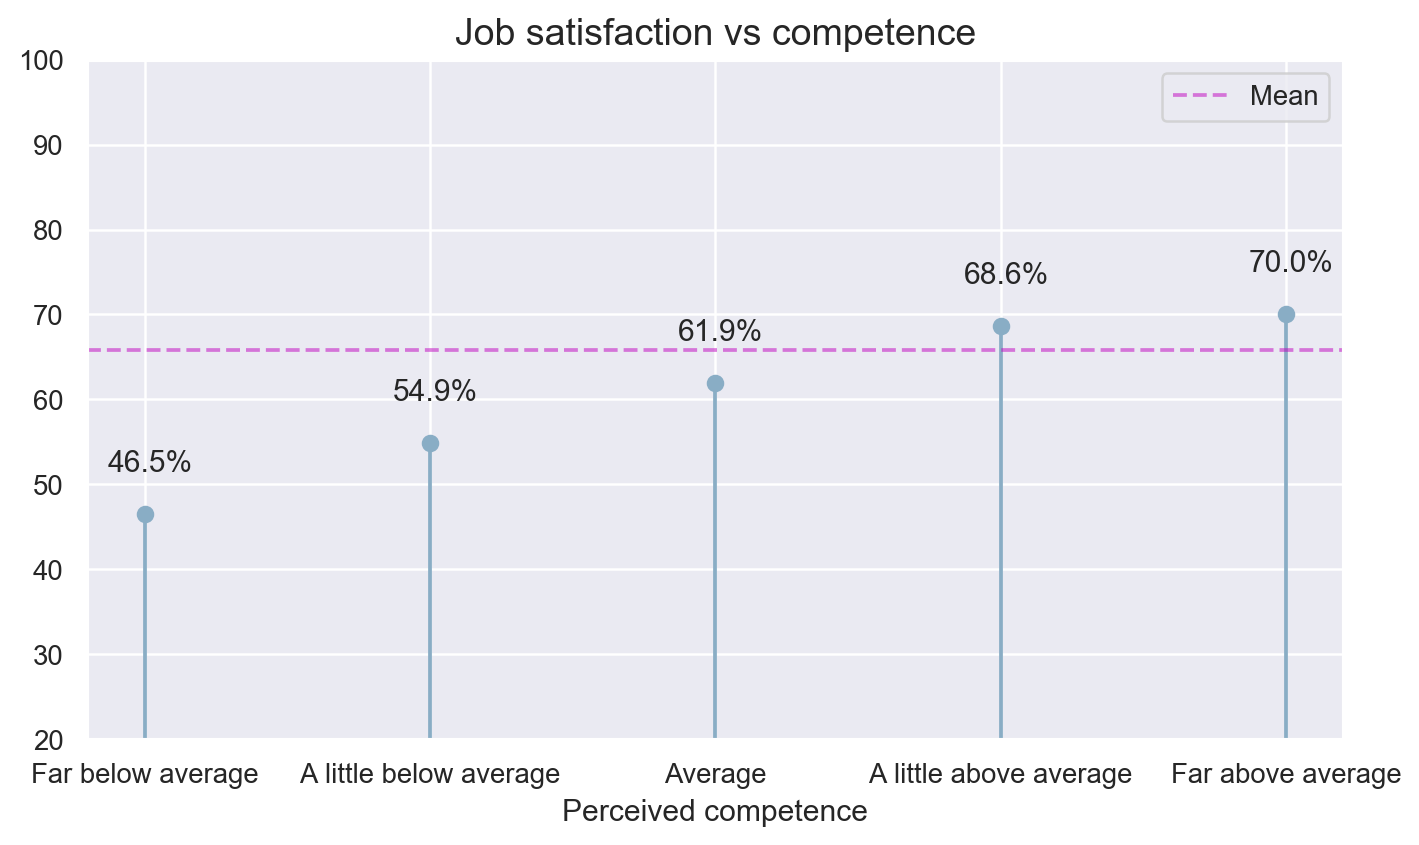

In [37]:
comp_satisfied = percentageSatisfied(column = 'ImpSyn').reindex(categories)
plt.figure(figsize=(9,5))
lollipop(categories, comp_satisfied, xshift= -0.13, yshift = 5)
plt.ylim(20,100);
plt.axhline(p_sat, color = 'm', ls = '--', alpha = 0.5, label = 'Mean')
plt.legend()
plt.title('Job satisfaction vs competence', fontsize = 15);
plt.xlabel('Perceived competence');

We can clearly see the fraction of satisfied developers growing with increasing competence.

Now, there's a caveat: **perceived** competence is necessarily subjective, and some people might be more likely to consider themselves competent than other. The people of Stack Overflow, in their own analysis of this data, found that men were more likely than women to give "above average" answers to this question.

I still think that the patterns in the plots are clear enough that they can be considered valid even if the underlying data is not exactly objective.

##### Job level

Unfortunately we don't have data on job levels (junior,senior, etc). The closest thing to that is the number of years spent coding as a professional, and the *MgrWant* column. The column contains the answer to "Would you like to become a manager some day?", and it  also includes the precious answer of those who are already managers.

I wanted to look at the "Manager" subset of the survey more closely because there's a bit of a *stereotype* around engineers, and technical workers in general, and the stereotype is that they would rather **remain on the "technical side"** of things instead of being saddled with people to manage and having to deal with project management, bureaucracy, etc.

In [38]:
# New binary 'manager' column 
survey_dev = survey_dev.assign(Manager='No')
survey_dev['Manager'] = np.where( (survey_dev['MgrWant'].str.contains('manager')),'Yes', survey_dev['Manager'])

managers = len(survey_dev.loc[survey_dev['Manager']=='Yes'])
mgn_percentage = np.round(100*managers/len(survey_dev),1)

In [39]:
print(f"There are {managers} managers among the survey takers. ({mgn_percentage}% of total)")

There are 12013 managers among the survey takers. (19.6% of total)


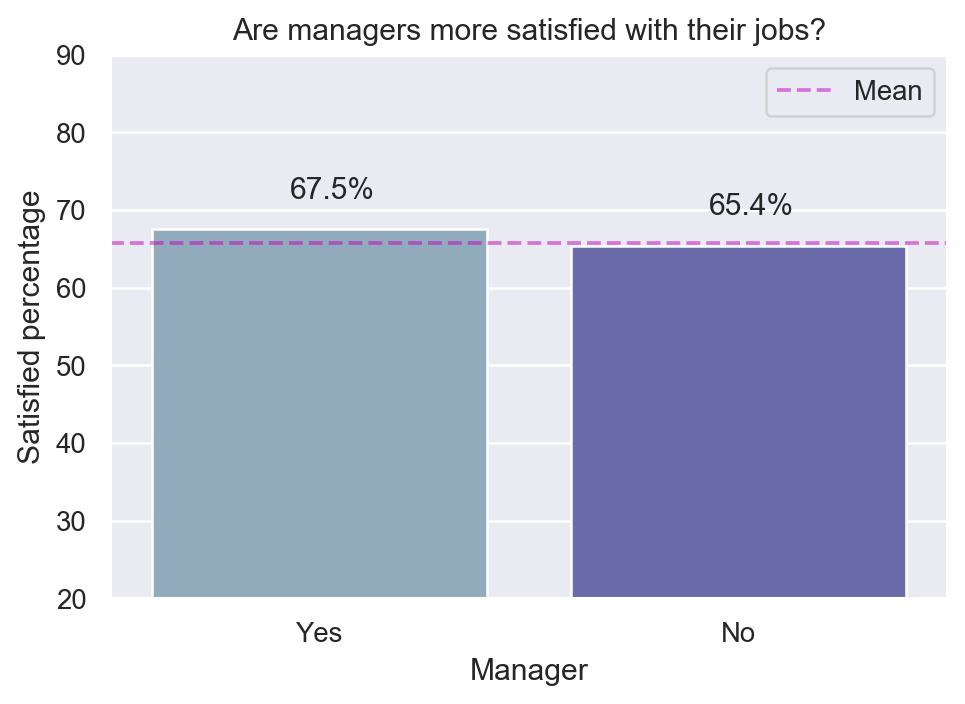

In [40]:
manager_cat= ['Yes', 'No']
manager_satisfied = percentageSatisfied(column = 'Manager', dataset = survey_dev).reindex(manager_cat)


sns.barplot(y=manager_satisfied, x = manager_cat)
for index, value in enumerate(manager_satisfied):
        plt.text(index- 0.07,value + 4,str(value)+'%')
plt.xlabel('Manager');
plt.ylim(20,90);
plt.axhline(p_sat, color = 'm', ls = '--', alpha = 0.5, label = 'Mean')
plt.legend()
plt.ylabel('Satisfied percentage');
plt.title('Are managers more satisfied with their jobs?');


Seems like managers are no less satisfied then their colleagues, and maybe even a bit more. Of course, being a manager usually correlates with higher compensation and recognition of competence, which as we've seen are predictors of job satisfaction.

## Conclusions

I think we've learned some interesting things in this analysis. Not all of the plots showed obvious patterns, but those that did provided some food for thought 

I'll take a moment to stress once more that these considerations were sometimes made by looking at a limited sample, and that a lot of the variables we looked at are correlated with each other.

Here's a summary of the findings:

\- **Gender:** men made up almost 90% of the survey respondents. Analyzing our relatively small sample of women and non-binary developers, women showed a slightly higher satisfaction than average, while non-binary people were well below the survey's average.

**- Age group:** developers over 40 years old reported a higher satisfaction rate then their younger counterparts. In turn, this can be related to competence and salary, since both usually grow with age.

\- **Perceived competence:** there's an evident positive correlation between feeling competent at work and feeling satisfied with a job. It's no surprise that people enjoy themselves more when they are working on something they're good at, but it was nice to see it show so clearly in the data

\- **Compensation:** job satisfaction clearly increased with compensation, with developers paid below average wages being the least satisfied group.

\- **Remote work:** the happiest group was the one that is allowed to work remotely for some time. People working remotely all the time were much less satisfied. Problems like isolation, disorganization and burnout are common among fully remote workers, and they might be the cause for this. Still, our sample of remote workers was a bit small.

I hope you've enjoyed this; the Stack Overflow survey offers a lot of exciting possibilities for analysis, so I'd like to thank them for making the data available. An idea could be to apply some clustering algorithms to identify different "types" of developers. And since the data is available starting from 2011, you could also look at how the responses have changed over time. I'm sure there are many more ways to approach this dataset.

Until next time,

Carolina